# AAIC Self Case study - 2
----

## 'Dog Breed Identification' : Determine the breed of a dog in an image

# 
# Selection of Best Final Model:

<b>1. I tried with the input shape (224,224,3) of the images and on top of InceptionResnet Model, I added some more dense layers along with a dropout layer but the accuracy got stuck at around 80% validation accuracy and got a log-loss of 1.04618.
    

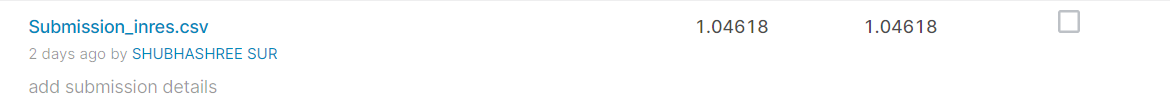

<b>2. I tried with the input shape (224,224,3) of the images and on top of InceptionResnet Model, added a convolutional block followed by a max pooling layer and then 2 dense layers and a dropout layer. Here I also played with callbacks like reduce on plateau to decay learning rates based on validation accuracy. The validation accuracy is found to be in the range of 77% to 80%. Got a test log-loss of 1.12515.

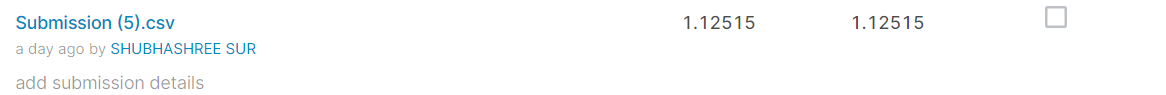

<b>3. I tried with the input shape (224,224,3) of the images with the Xception model. Added 2 dense layers on top of it and used callbacks to decay learning rate. Was able to reach a validation accuracy upto 89%. Got a test log-loss of 0.32724. 

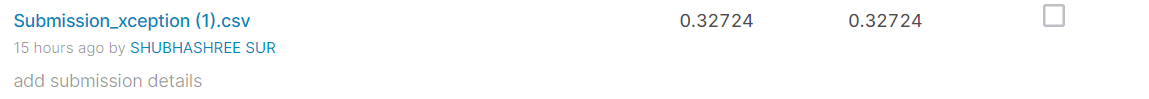

<b>4. I tried the input shape of (224,224,3) of the images with the InceptionResnet model. Added just 2 dense layers along with 1 dropout layer. Was able to reach a validation accuracy of 92%. On test data, got the least log-loss of 0.29702.

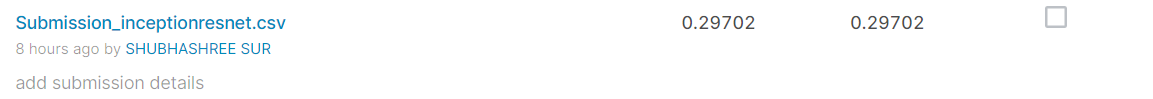

<b>5. I tried to train the same above model for more no. of epochs with learning rate decay callbacks. But found the validation accuracy to have decreased. Also the log-loss on test data reduced.

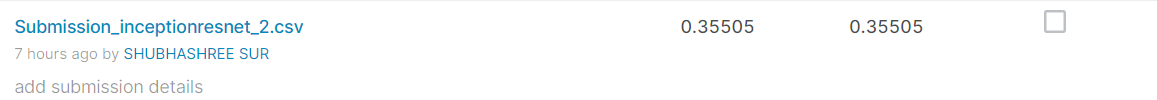

<font color='deep blue'> <b>Comment: So we see that we got the least test log-loss in case of 4th model. Previously we used the image shape as (331,331,3) and a got a test log-loss of 0.29912. Now using the image shape as (224,224,3) has helped us reduced the log-loss to 0.29702. Though the decrease is negligible, still it is lesser. Thus, we select it as our final model and proceed with that.

# Code:

<b> Loading the libraries

In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import cv2 
import os 
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential
from keras.layers import Dense,MaxPooling2D,Dropout,Conv2D,GlobalAveragePooling2D,Flatten

<b> Loading the dataset

In [44]:
train = pd.read_csv('labels.csv')

#getting the path to the images
train['path'] = "train/" + train['id'] + '.jpg'
train.head()

,id,breed,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


<b> Label Encoding

In [48]:
train['label']=train.breed

le=LabelEncoder()

train.label=le.fit_transform(train.label)
train.head()

,id,breed,path,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,49


<b> Train and validation split

In [49]:
train, val = train_test_split(train, test_size=0.10, random_state=42)

<b> ImageDataGenerator to the load the images in batches while training

In [9]:
datagen = ImageDataGenerator(preprocessing_function = keras.applications.nasnet.preprocess_input,
                      shear_range = 0.2,
                     horizontal_flip = True)

train_df = datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='breed',
    shuffle=True,
    class_mode='categorical',
    target_size=(224,224)
)

val_df = datagen.flow_from_dataframe(
    dataframe=val,
    x_col='path',
    y_col='breed',
    shuffle=True,
    class_mode='categorical',
    target_size=(224,224)
)


Found 9199 validated image filenames belonging to 120 classes.
Found 1023 validated image filenames belonging to 120 classes.


# InceptionResNetV2 Model

In [10]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

#loading the pre-trained model
transfer_model = InceptionResNetV2(include_top = False,
                                   weights ='imagenet',
                                  input_shape = (224,224,3))

#making all the layers non-trainable so that it takes the weights of the pre trained model on imagenet dataset
transfer_model.trainable = False  

<b> Adding our own dense layers

In [31]:
model = Sequential()
model.add(transfer_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))



model.add(Dense(120,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
Total params: 54,761,048
Trainable params: 424,312
Non-t

In [8]:
os.mkdir("save_model")

<b> Callbacks

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

#to save the trained models
filepath="./save_model/case_study_2_inres_model_{epoch:02d}.h5"
checkpoint=ModelCheckpoint(filepath=filepath, monitor='accuracy',  verbose=1, save_best_only=True, mode='auto',save_freq='epoch')

<b> Compiling the model

In [32]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])

<b> Fitting the model

In [34]:
history=model.fit(train_df,epochs = 30,validation_data = val_df,callbacks = [checkpoint])

Epoch 1/30
 32/288 [==>...........................] - ETA: 26:28 - loss: 4.1864 - accuracy: 0.2090

KeyboardInterrupt: 

<b> Loading the best model

In [36]:
model.load_weights("save_model/case_study_2_inres_model_19.h5")

<b> Metric plots: Accuracy vs epoch and loss vs epoch plots

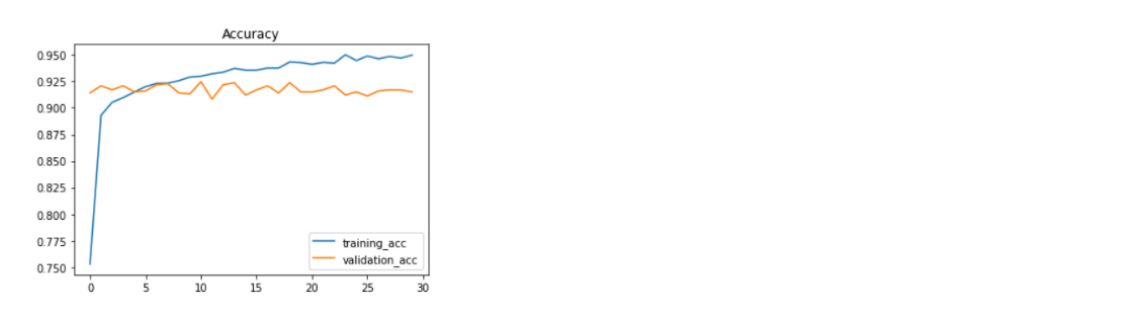

In [7]:
plt.plot(history.epoch,history.history['accuracy'],label ="training_acc")
plt.plot(history.epoch,history.history['val_accuracy'],label ="validation_acc")
plt.title("Accuracy")
plt.legend()
plt.show()

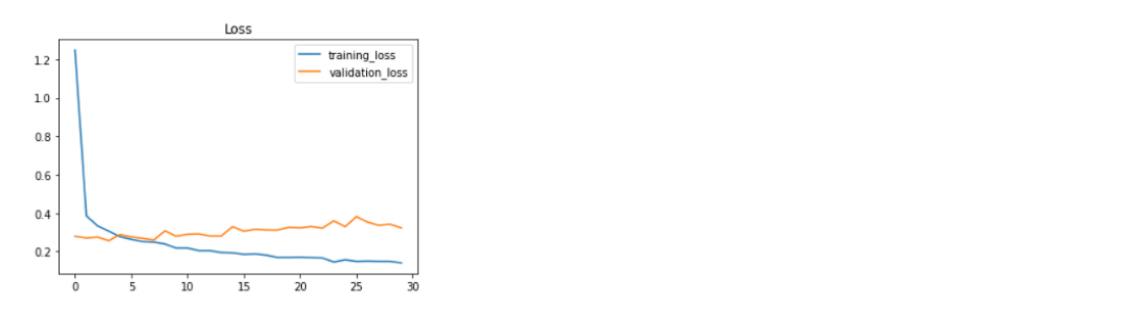

In [8]:
plt.plot(history.epoch,history.history["loss"],label = "training_loss")
plt.plot(history.epoch,history.history["val_loss"],label = "validation_loss")
plt.title("Loss")
plt.legend()
plt.show()

# Some random test images prediction and visualization by the model

In [26]:
#getting the random validation indices
indices=np.random.choice(list(val.index),10,replace=False)
indices

array([ 1175,  5763,  3172,   735,  4246,  2954, 10211,  2377,  2029,
        2554])

In [30]:
#getting the dataframe
test_df=pd.DataFrame(val,index=list(indices))
test_df

,id,breed,path
1175,1d56de1015dbe9ba9d54135a7b33636d,bull_mastiff,train/1d56de1015dbe9ba9d54135a7b33636d.jpg
5763,919275bc732b771a349d6515bacad30f,airedale,train/919275bc732b771a349d6515bacad30f.jpg
3172,4e4173a3a2e7d49f43ddfe3f167ea397,pekinese,train/4e4173a3a2e7d49f43ddfe3f167ea397.jpg
735,123c19c8d168e7704273cb7174351821,vizsla,train/123c19c8d168e7704273cb7174351821.jpg
4246,69ba753079fe58a8bb749fe4bb0beb9a,newfoundland,train/69ba753079fe58a8bb749fe4bb0beb9a.jpg
2954,490c833562a01e699bc8dd9747ba33f4,rhodesian_ridgeback,train/490c833562a01e699bc8dd9747ba33f4.jpg
10211,ffc2b6b9133a6413c4a013cff29f9ed2,irish_setter,train/ffc2b6b9133a6413c4a013cff29f9ed2.jpg
2377,3b203ec8a73be8cc1bce1766abbd9f15,japanese_spaniel,train/3b203ec8a73be8cc1bce1766abbd9f15.jpg
2029,3276746904f57c4fcbb794bbbb27e7dc,flat-coated_retriever,train/3276746904f57c4fcbb794bbbb27e7dc.jpg
2554,3f974ba3e0c33d02274cc3889d146a74,clumber,train/3f974ba3e0c33d02274cc3889d146a74.jpg


0it [00:00, ?it/s]

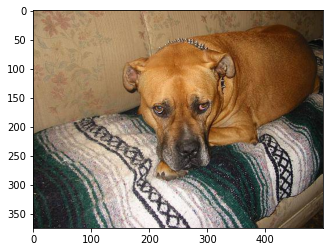

Actual breed:  bull_mastiff
Predicted breed:  bull_mastiff with a probability of 90.095 %


----------------------------------------------------------------------------------------------------





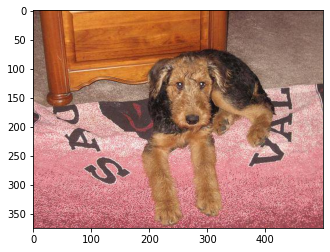

Actual breed:  airedale
Predicted breed:  airedale with a probability of 99.917 %


----------------------------------------------------------------------------------------------------





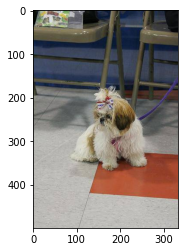

Actual breed:  pekinese
Predicted breed:  shih-tzu with a probability of 85.025 %


----------------------------------------------------------------------------------------------------





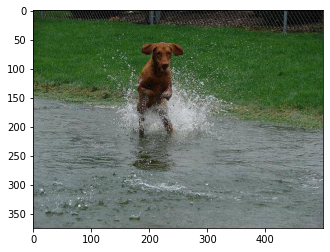

Actual breed:  vizsla
Predicted breed:  vizsla with a probability of 99.968 %


----------------------------------------------------------------------------------------------------





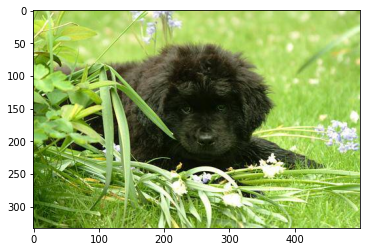

Actual breed:  newfoundland
Predicted breed:  newfoundland with a probability of 99.95 %


----------------------------------------------------------------------------------------------------





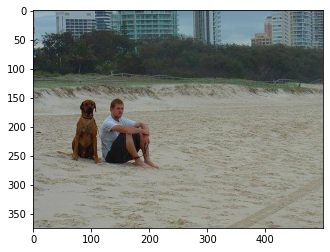

Actual breed:  rhodesian_ridgeback
Predicted breed:  rhodesian_ridgeback with a probability of 82.676 %


----------------------------------------------------------------------------------------------------





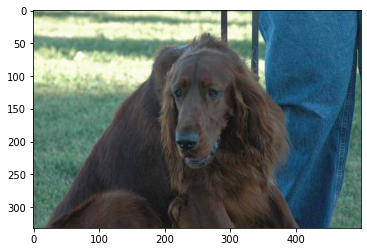

Actual breed:  irish_setter
Predicted breed:  irish_setter with a probability of 99.818 %


----------------------------------------------------------------------------------------------------





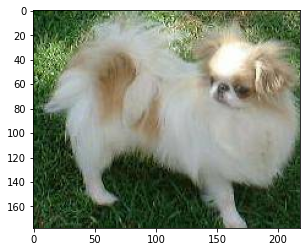

Actual breed:  japanese_spaniel
Predicted breed:  japanese_spaniel with a probability of 99.484 %


----------------------------------------------------------------------------------------------------





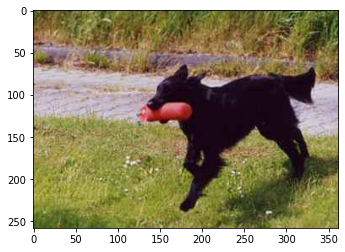

Actual breed:  flat-coated_retriever
Predicted breed:  flat-coated_retriever with a probability of 99.989 %


----------------------------------------------------------------------------------------------------





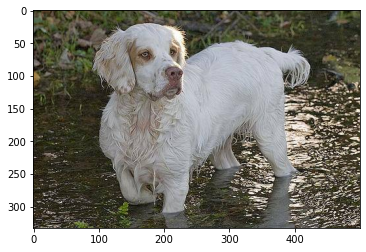

Actual breed:  clumber
Predicted breed:  clumber with a probability of 99.886 %


----------------------------------------------------------------------------------------------------





In [58]:
for i,j in tqdm(zip(test_df.breed.values,test_df.path.values)):
    
    #getting the image and resizing it
    img=image.load_img(path=j,target_size=(224,224,3))
    img=image.img_to_array(img)
    test_img=img.reshape((1,224,224,3))
    
    #prediction using the trained model
    prediction = model.predict(test_img/255)
    
    img = Image.open(j)
    plt.imshow(img)
    plt.show()
    print("Actual breed: ",i)
    print("Predicted breed: ",le.inverse_transform([np.argmax(prediction)])[0], 'with a probability of',round(np.max(prediction)*100,3),'%' )
    print("\n")
    print("--"*50)
    print("\n\n")
    
    
    

<font color='deep blue'> <b> Comment: We see that out of 10 images, 9 images are predicted correctly with a probability of 90% most of the times. Thus we can conclude that our model has been trained properly.

# Prediction on the dataset provided for the competition

In [2]:
#loading the file
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [3]:
#getting the actual path
submission['id']='test/'+submission['id']+'.jpg'
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,test/000621fb3cbb32d8935728e48679680e.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,test/00102ee9d8eb90812350685311fe5890.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,test/0012a730dfa437f5f3613fb75efcd4ce.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,test/001510bc8570bbeee98c8d80c8a95ec1.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,test/001a5f3114548acdefa3d4da05474c2e.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [4]:
#ImageDataGenerator for test images
testgen = ImageDataGenerator(preprocessing_function=keras.applications.inception_resnet_v2.preprocess_input)

In [5]:
test = testgen.flow_from_dataframe(
submission,
    x_col = 'id',
    y_col = None,
    target_size = (224,224),
    class_mode = None,
    shuffle = False
    
)

Found 10357 validated image filenames.


In [30]:
#prediction of test images
pred = model.predict(test,verbose =2)

In [31]:
submission.iloc[:,1:] =pred

In [6]:
#getting the ids only
def id(st):
    return st.split('/')[-1].split('.')[0]

submission['id']=submission['id'].apply(id)

submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,4.606702e-08,1.912321e-08,7.687991e-09,3.624340e-09,8.928076e-10,1.343649e-10,9.600224e-11,4.917335e-11,8.316462e-12,...,2.410623e-08,3.000862e-10,2.230039e-09,2.577145e-09,2.942198e-09,4.540087e-11,6.162876e-11,6.521180e-09,2.083564e-08,1.126570e-08
1,00102ee9d8eb90812350685311fe5890,1.278150e-09,9.523640e-10,1.041457e-12,5.694618e-10,1.829703e-09,1.088364e-09,9.816469e-11,4.989307e-09,1.027733e-10,...,7.283114e-09,5.506246e-11,6.031549e-09,5.282844e-08,2.924560e-09,3.160198e-11,1.298367e-06,3.010945e-09,2.787674e-11,1.249985e-10
2,0012a730dfa437f5f3613fb75efcd4ce,3.241762e-09,1.473675e-10,8.051895e-08,2.768598e-09,1.811903e-09,5.147564e-08,3.079604e-10,2.783428e-13,6.103996e-11,...,1.386541e-07,2.607447e-10,1.757822e-09,7.618468e-08,3.765505e-09,4.954747e-08,9.871660e-11,5.155159e-08,1.232534e-08,4.739111e-08
3,001510bc8570bbeee98c8d80c8a95ec1,2.148578e-06,2.438481e-11,1.618218e-11,3.951195e-08,1.239424e-10,1.193252e-06,5.346434e-12,5.764881e-10,5.546200e-10,...,5.871470e-09,7.560103e-11,4.472665e-11,1.104664e-08,7.423451e-09,2.218579e-09,2.406101e-09,5.162242e-08,6.117979e-12,2.925231e-09
4,001a5f3114548acdefa3d4da05474c2e,2.561808e-04,1.831295e-06,8.159315e-10,1.328078e-09,7.416303e-09,9.661741e-07,9.421697e-08,1.307109e-06,8.044028e-09,...,1.184815e-06,1.444206e-08,1.988682e-07,6.057290e-07,5.231392e-10,3.005593e-09,3.690848e-09,5.547583e-07,2.008089e-08,4.290623e-07


In [33]:
#saving the file
submission.to_csv('Submission_inceptionresnet.csv',index=False)